# 3 PCA图像压缩
## 3.1代码实现

In [1]:
import numpy as np
from PIL import Image

#读取图片
img=np.array(Image.open('aa.jpg'))
print('Shape of the Image is',img.shape)

Shape of the Image is (960, 960, 3)


In [15]:
#my_PCA类，考虑到本题为图像压缩任务，故去除题目一中my_PCA内的白化操作，同时只保留SVD方法的函数
class my_PCA(object):
    def __init__(self,n_components):
        self.num_components=n_components
    
    def fit_SVD(self,Train_data):
        eig_vectors,eig_values,v=np.linalg.svd(Train_data.T)#奇异值分解，得到奇异矩阵和特征值,特征值由大到小排列
        self.proj_matrix=eig_vectors[:,:self.num_components]#挑选num_components个向量组成投影矩阵
        
    def transform(self,Raw_data):
        new_data=Raw_data.dot(self.proj_matrix)                #将数据投影到新方向上
        
        return new_data

#矩阵分块函数
def mat_spilit(mat,NX,NY):
    W=int(mat.shape[0]/NX)#分块宽度
    H=int(mat.shape[1]/NY)#分块高度
    result=np.zeros((NX*NY,W*H))
    for x in range(NX):
        for y in range(NY):
            result[x*NX+y,:]=np.reshape(mat[x*W:(x+1)*W,y*H:(y+1)*H],W*H)#取对应矩阵块并reshape为列向量

    return result

#矩阵重建函数
def mat_rebuild(spilit,NX,NY,W,H):
    result=np.zeros((NX*W,NY*H))
    for x in range(NX):
        for y in range(NY):
            result[x*W:(x+1)*W,y*H:(y+1)*H]=np.reshape(spilit[x*NX+y,:],(W,H))#取列向量并reshape为对应矩阵块

    return result

#PCA压缩函数
def PCA_compress(data_R,data_G,data_B,num_components):
    #RGB三个通道使用完全一样的操作
    pca_R = my_PCA(n_components=num_components)
    pca_R.fit_SVD(data_R)#利用SVD提取得到指定数量个主成分
    factor_R=pca_R.transform(data_R)#将原始数据投影在主成分上，得到投影系数
    
    pca_G = my_PCA(n_components=num_components)
    pca_G.fit_SVD(data_G)
    factor_G=pca_G.transform(data_G)
    
    pca_B = my_PCA(n_components=num_components)
    pca_B.fit_SVD(data_B)
    factor_B=pca_B.transform(data_B)
    
    compress_ratio=data_R.size/(factor_R.size+pca_R.proj_matrix.size)#计算压缩比=原图矩阵元数目/(压缩后各主分量矩阵元数目和+投影系数数目和)

    return pca_R.proj_matrix,factor_R,pca_G.proj_matrix,factor_G,pca_B.proj_matrix,factor_B,compress_ratio#返回投影矩阵、投影系数、压缩比

#PCA重建函数
def PCA_rebuild(proj_matrix_R,factor_R,proj_matrix_G,factor_G,proj_matrix_B,factor_B):
    rebuild_R=np.dot(factor_R,proj_matrix_R.T)#由主分量矩阵和投影系数相乘，恢复得到矩阵
    rebuild_G=np.dot(factor_G,proj_matrix_G.T)
    rebuild_B=np.dot(factor_B,proj_matrix_B.T)
    
    return rebuild_R,rebuild_G,rebuild_B#返回重建后的矩阵

#定量评价函数
def eval(img,rebuild_img):
    loss=np.mean(np.abs(img-rebuild_img))#定义评价指标为-log(全图像素平均差值（像素值归一化到[0,1]）)
    
    return -np.log(loss)

#压缩与重构函数
def compress_rebuild(img,spilit,component):
    #分离RGB通道，将三个通道用相同方法处理
    img_R=img[:,:,0]
    img_G=img[:,:,1]
    img_B=img[:,:,2]
    W,H=img_R.shape
    
    data_R=mat_spilit(img_R,spilit,spilit)#三个通道分别分块，reshape为列向量
    data_G=mat_spilit(img_G,spilit,spilit)
    data_B=mat_spilit(img_B,spilit,spilit)

    proj_matrix_R,factor_R,proj_matrix_G,factor_G,proj_matrix_B,factor_B,compress_ratio=PCA_compress(data_R,data_G,data_B,component)#三通道分别压缩得到投影矩阵和投影系数
    rebuild_data_R,rebuild_data_G,rebuild_data_B=PCA_rebuild(proj_matrix_R,factor_R,proj_matrix_G,factor_G,proj_matrix_B,factor_B)#利用投影矩阵和投影系数分别重建三个通道

    rebuild_img_R=np.clip(mat_rebuild(rebuild_data_R,spilit,spilit,int(W/spilit),int(H/spilit))/255,0,1)#将像素值归一化，列向量reshape成矩阵
    rebuild_img_G=np.clip(mat_rebuild(rebuild_data_G,spilit,spilit,int(W/spilit),int(H/spilit))/255,0,1)
    rebuild_img_B=np.clip(mat_rebuild(rebuild_data_B,spilit,spilit,int(W/spilit),int(H/spilit))/255,0,1)

    rebuild_img=np.concatenate((rebuild_img_R[:,:,np.newaxis],rebuild_img_G[:,:,np.newaxis],rebuild_img_B[:,:,np.newaxis]),axis=-1)#连接三通道得到图像
    
    return rebuild_img,compress_ratio,eval(img/255,rebuild_img),proj_matrix_R#返回重构图像、压缩率、重建质量、R通道投影矩阵

In [5]:
spilit_list=[8,16,32,64]#设置网格参数，探究分块数和主成分数的影响
num_list=[5,10,15,20,25]
acc_record=np.zeros((len(spilit_list),len(num_list)))#记录重建质量
ratio_record=np.zeros((len(spilit_list),len(num_list)))#记录压缩比

for x in range(len(spilit_list)):
    for y in range(len(num_list)):
        _,compress_ratio,acc,_=compress_rebuild(img,spilit_list[x],num_list[y])        
        ratio_record[x][y]=compress_ratio#记录压缩比
        acc_record[x][y]=acc#记录重建质量

Text(0.5, 0.92, 'Compression Ratio under Different Compress Settings')

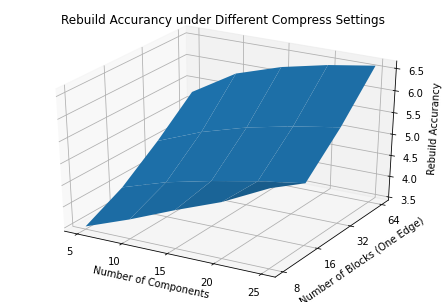

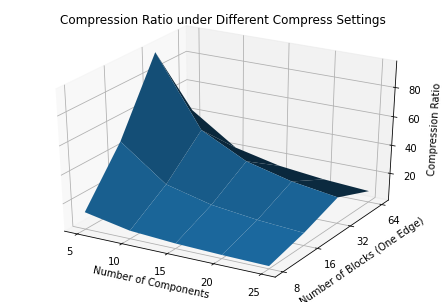

In [6]:
#画出压缩比、重建质量随分块数目、主成分数目的变化
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x, y = np.meshgrid(range(len(num_list)),range(len(spilit_list)))

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, acc_record)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Number of Blocks (One Edge)')
ax.set_zlabel('Rebuild Accurancy')
ax.set_xticks(range(len(num_list)))
ax.set_yticks(range(len(spilit_list)))
ax.set_xticklabels(num_list)
ax.set_yticklabels(spilit_list)
plt.title('Rebuild Accurancy under Different Compress Settings')

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, ratio_record)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Number of Blocks (One Edge)')
ax.set_zlabel('Compression Ratio')
ax.set_xticks(range(len(num_list)))
ax.set_yticks(range(len(spilit_list)))
ax.set_xticklabels(num_list)
ax.set_yticklabels(spilit_list)
plt.title('Compression Ratio under Different Compress Settings')

Text(0.5, 0, 'Compressssion ratio:31.933471933471935\nRebuild accuracy:5.2615203950132505')

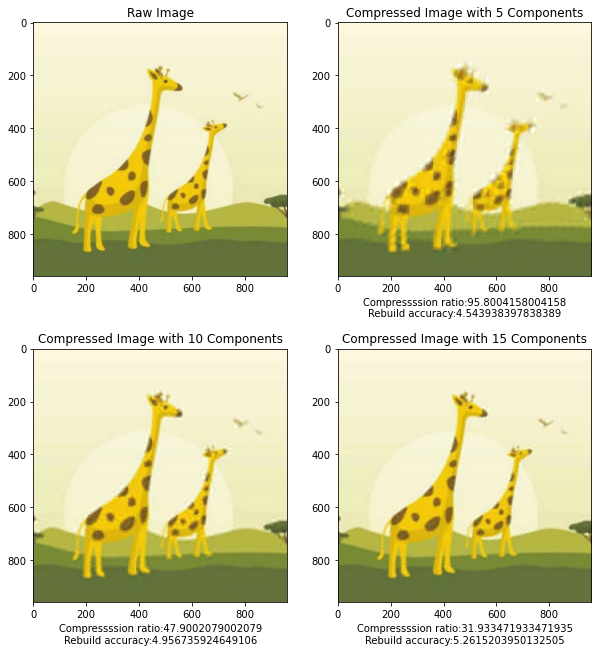

In [16]:
#选取分块数为32*32=1024，主成分数15个进行图像压缩并显示结果
plt.figure(figsize=(10,11))
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Raw Image')

plt.subplot(2,2,2)
rebuild_img,compress_ratio,acc,_=compress_rebuild(img,32,5)
plt.imshow(rebuild_img)
plt.title('Compressed Image with 5 Components')
plt.xlabel('Compressssion ratio:{}\nRebuild accuracy:{}'.format(compress_ratio,acc))
plt.subplot(2,2,3)
rebuild_img,compress_ratio,acc,_=compress_rebuild(img,32,10)
plt.imshow(rebuild_img)
plt.title('Compressed Image with 10 Components')
plt.xlabel('Compressssion ratio:{}\nRebuild accuracy:{}'.format(compress_ratio,acc))
plt.subplot(2,2,4)
rebuild_img,compress_ratio,acc,proj_matrix_R=compress_rebuild(img,32,15)
plt.imshow(rebuild_img)
plt.title('Compressed Image with 15 Components')
plt.xlabel('Compressssion ratio:{}\nRebuild accuracy:{}'.format(compress_ratio,acc))

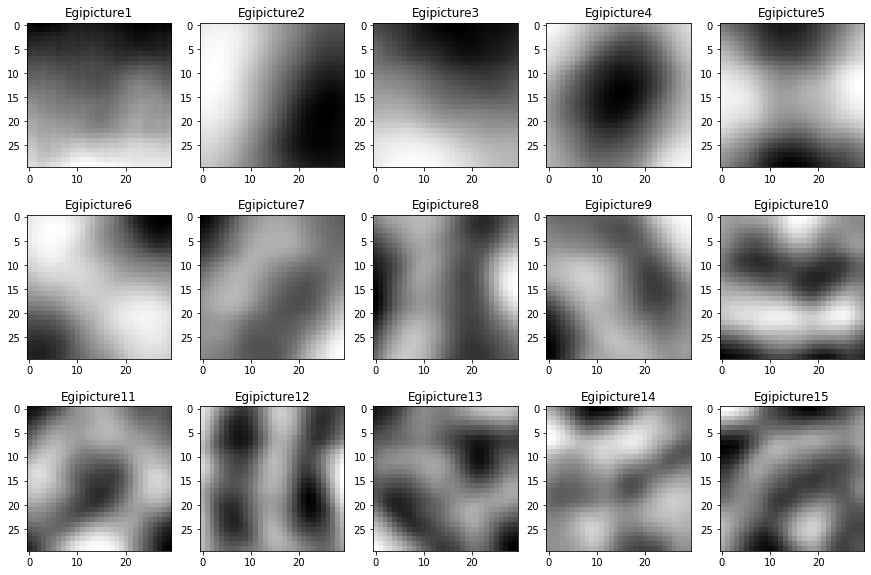

In [19]:
#画出取15个主分量时R通道的特征图
plt.figure(figsize=(15,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(np.reshape(proj_matrix_R[:,i],(30,30)),cmap='gray')
    plt.title('Egipicture{}'.format(i+1))

## 3.2 实验分析
### 3.2.1 实验方案
本实验利用PCA的方法进行图像压缩与重建。实验方案与步骤如下：
1. 由于彩色图像分为RGB三个通道，在本实验中先将三个通道分离，再分别进行PCA压缩与重建。
2. 首先对图像矩阵进行分块，每个小块reshape为一个列向量，将所有小块对应列向量合并成矩阵，得到了待降维的目标矩阵。
3. 用SVD对上述矩阵做PCA，根据指定的主成分数量，得到对应的投影矩阵和投影系数。由此，之需要存储这个投影矩阵和对应投影系数即可有损恢复原图像。可以计算压缩比=原图矩阵元数目/(压缩后各主分量矩阵元数目和+投影系数数目和).
4. 重建图像时，用投影系数对投影矩阵（即主成分矩阵）的各分量进行线性叠加，即可得到重建后的图像。定义重建准确度=-log（归一化像素值的平均误差）。

### 3.2.2 实验结果分析
下面对实验结果做几点分析：
+ 根据不同分块数目、主成分数目结果的变化曲面图可以得到，相同分块数目时，选取主成分数目越多则重建效果越好，相应的压缩比则会下降；相同主成分数目时，图像分块增多时，压缩比首先会上升（这是由于分块增多从而每个主成分维度降低导致的），但分块数目超过一定阈值后，压缩比反而下降（这是由于分块数增多导致需要存储的投影系数增多导致的）。因此，在实际应用中，应当选择合适的分块数目（如本图像取32\*32较好，故选取32\*32分块画出不同主成分数目下的重建图像）。对于主成分数目，如果希望获得好的重建质量，则需要取较大值；如果希望获得较高的压缩比，则取较小值。
+ 根据绘制出的特征图可以发现，特征图包括较为平滑的低频分量和黑白变化明显的高频分量。由低频、高频分量可以线性组合出各种图像，与二维离散傅里叶变换有一定的相似之处。
+ 从画出的重建图像可以看出，压缩比较高的时候图像细节损失较大，保证图像细节的情况下压缩比又较低。因此，PCA方法只是一种较为粗糙的算法，实际中还需要更高级的图像压缩方法来满足实际需求。如JPEG编码方式，采用了DCT变换、zig-zag扫描、熵编码等步骤，可以取得较为理想的压缩效果。